In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import anndata as ad
import scvelo as scv
import scipy as sp
from scipy import stats
from scipy import special
from scipy.stats import poisson,norm
from scipy.special import j_roots
from scipy.special import beta as beta_fun 
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import seaborn as sns
import random

import test.utils as test

In [2]:
scv.set_figure_params(dpi=100, color_map = 'viridis_r')
scv.settings.verbosity = 1
sc.logging.print_header()

scanpy==1.7.2 anndata==0.8.0 umap==0.4.1 numpy==1.23.1 scipy==1.8.0 pandas==1.4.1 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.9


In [3]:
adata = sc.read_h5ad('data/test_classifier.h5ad')

In [4]:
adata

AnnData object with n_obs × n_vars = 682 × 3134
    obs: 'leiden', 'clusters'
    var: 'gene_name', 'chromosome', 'autosomes', 'nuclear', 'Ribosomal_prot', 'sum_allele_1', 'sum_allele_2', 'ratio_allele_1', 'ratio_allele_2', 'ratio_sum_allele_1', 'ratio_sum_allele_2', 'ratio_mean_allele_1', 'ratio_mean_allele_2', 'ratio_std_allele_1', 'ratio_std_allele_2', 'p_value'
    uns: 'leiden', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    layers: 'ratio_allele_1', 'ratio_allele_2', 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

In [5]:
classes = [
    'bi_allelic', #class 0 : KS >=0.00000005 and std >0.1 and <=0.4
    'parent_of_origin', #class 1: KS <0.00000005 and ratio < 0.1 and ratio >0.9,
    'zero_inflted', #the weird one that are super 0 inflated. So KS >=0.005 and std < 0.1 or std >=0.6
    'other', #class 2:  (KS <0.00000005 and 0.1 < ratio < 0.9) + (KS >=0.00000005 and std > 0.4)
]

In [6]:
# group_1 and group _2 are primary division based on KS value threshold of 0.005
group_1 = adata.var[adata.var.p_value >= 0.00000005]
group_2  = adata.var[adata.var.p_value < 0.00000005]

In [7]:
bi_allelic = group_1[(group_1.ratio_std_allele_1 >= 0.1) & (group_1.ratio_std_allele_1 <= 0.4)]
bi_allelic_index = bi_allelic.index
len(bi_allelic_index)

1264

In [8]:
parent_of_origin = group_2[ (group_2.ratio_allele_1 <= 0.1) | 
                            (group_2.ratio_allele_1 >= 0.9) | 
                            (group_2.ratio_allele_2 <= 0.1) | 
                            (group_2.ratio_allele_2 >= 0.9) ]
parent_of_origin_index = parent_of_origin.index
len(parent_of_origin_index)

48

In [9]:
# zero_inflated = group_1[(group_1.ratio_std_allele_1 <= 0.0001) | (group_1.ratio_std_allele_1 >= 0.6)]
zero_inflated = group_1[(group_1.sum_allele_1 < 50) | (group_1.sum_allele_2 < 50)]
 

zero_inflated_index = zero_inflated.index
len(zero_inflated_index)

1305

In [10]:
zero_inflated_sorted = zero_inflated.sort_values('sum_allele_1', ascending=False)

In [11]:
zero_inflated_sorted

,gene_name,chromosome,autosomes,nuclear,Ribosomal_prot,sum_allele_1,sum_allele_2,ratio_allele_1,ratio_allele_2,ratio_sum_allele_1,ratio_sum_allele_2,ratio_mean_allele_1,ratio_mean_allele_2,ratio_std_allele_1,ratio_std_allele_2,p_value
ENSMUSG00000115759,Gm18787,15,autosome,nuclear,other protein,214.0,32.0,0.869919,0.130081,78.550000,5.450000,0.935119,0.064881,0.191835,0.191835,0.001846
ENSMUSG00000087528,9830144P21Rik,2,autosome,nuclear,other protein,127.0,10.0,0.927007,0.072993,70.083333,6.916667,0.910173,0.089827,0.272981,0.272981,0.007106
ENSMUSG00000019851,Perp,10,autosome,nuclear,other protein,114.0,45.0,0.716981,0.283019,38.145455,12.854545,0.747950,0.252050,0.402051,0.402051,0.833173
ENSMUSG00000111511,AC160966.1,9,autosome,nuclear,other protein,109.0,34.0,0.762238,0.237762,70.466667,22.533333,0.757706,0.242294,0.423099,0.423099,0.068187
ENSMUSG00000054626,Xlr,X,X,nuclear,other protein,92.0,2.0,0.978723,0.021277,6.000000,2.000000,0.750000,0.250000,0.462910,0.462910,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000059077,Pth,7,autosome,nuclear,other protein,0.0,8.0,0.000000,1.000000,0.000000,6.000000,0.000000,1.000000,0.000000,0.000000,1.000000
ENSMUSG00000056973,Ces1d,8,autosome,nuclear,other protein,0.0,3.0,0.000000,1.000000,0.000000,2.000000,0.000000,1.000000,0.000000,0.000000,1.000000
ENSMUSG00000054662,Ano9,7,autosome,nuclear,other protein,0.0,2.0,0.000000,1.000000,0.000000,2.000000,0.000000,1.000000,0.000000,0.000000,1.000000
ENSMUSG00000115760,Gm18909,14,autosome,nuclear,other protein,0.0,5.0,0.000000,1.000000,0.000000,3.000000,0.000000,1.000000,0.000000,0.000000,1.000000


In [12]:
bi_allelic_sorted = bi_allelic.sort_values('sum_allele_1', ascending=False)

In [13]:
bi_allelic_sorted

,gene_name,chromosome,autosomes,nuclear,Ribosomal_prot,sum_allele_1,sum_allele_2,ratio_allele_1,ratio_allele_2,ratio_sum_allele_1,ratio_sum_allele_2,ratio_mean_allele_1,ratio_mean_allele_2,ratio_std_allele_1,ratio_std_allele_2,p_value
ENSMUSG00000024529,Lox,18,autosome,nuclear,other protein,139710.0,158741.0,0.468117,0.531883,323.181554,358.818446,0.473873,0.526127,0.103046,0.103046,1.504975e-03
ENSMUSG00000025290,Rps24,14,autosome,nuclear,Ribosomal protein,118051.0,104609.0,0.530185,0.469815,361.997087,320.002913,0.530788,0.469212,0.110395,0.110395,8.218191e-07
ENSMUSG00000062006,Rpl34,3,autosome,nuclear,Ribosomal protein,114728.0,107155.0,0.517065,0.482935,347.850286,334.149714,0.510044,0.489956,0.238214,0.238214,2.148393e-01
ENSMUSG00000024659,Anxa1,19,autosome,nuclear,other protein,108415.0,106414.0,0.504657,0.495343,342.372272,339.627728,0.502012,0.497988,0.105449,0.105449,9.919997e-01
ENSMUSG00000071644,Eef1g,19,autosome,nuclear,other protein,96147.0,95795.0,0.500917,0.499083,343.559589,338.440411,0.503753,0.496247,0.202258,0.202258,6.594703e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000047180,Neurl3,1,autosome,nuclear,other protein,1.0,21.0,0.045455,0.954545,1.000000,9.000000,0.100000,0.900000,0.316228,0.316228,1.000000e+00
ENSMUSG00000031760,Mt3,8,autosome,nuclear,other protein,1.0,17.0,0.055556,0.944444,1.000000,10.000000,0.090909,0.909091,0.301511,0.301511,1.000000e+00
ENSMUSG00000051716,Apon,10,autosome,nuclear,other protein,1.0,9.0,0.100000,0.900000,1.000000,7.000000,0.125000,0.875000,0.353553,0.353553,1.000000e+00
ENSMUSG00000106450,Gm43018,5,autosome,nuclear,other protein,1.0,12.0,0.076923,0.923077,1.000000,9.000000,0.100000,0.900000,0.316228,0.316228,1.000000e+00


In [14]:
other_1 = group_2[ ((group_2.ratio_allele_1 > 0.1) & 
                   (group_2.ratio_allele_1 < 0.9)) | 
                   ((group_2.ratio_allele_2 > 0.1) & 
                   (group_2.ratio_allele_2 < 0.9)) ]
other_2 = group_1[(group_1.ratio_std_allele_1 > 0.4) & (group_1.ratio_std_allele_1 < 0.7)]
other = pd.concat([other_1, other_2])
other_index = other.index
len(other_index)

1238

In [15]:
# Check 1 random data from each class

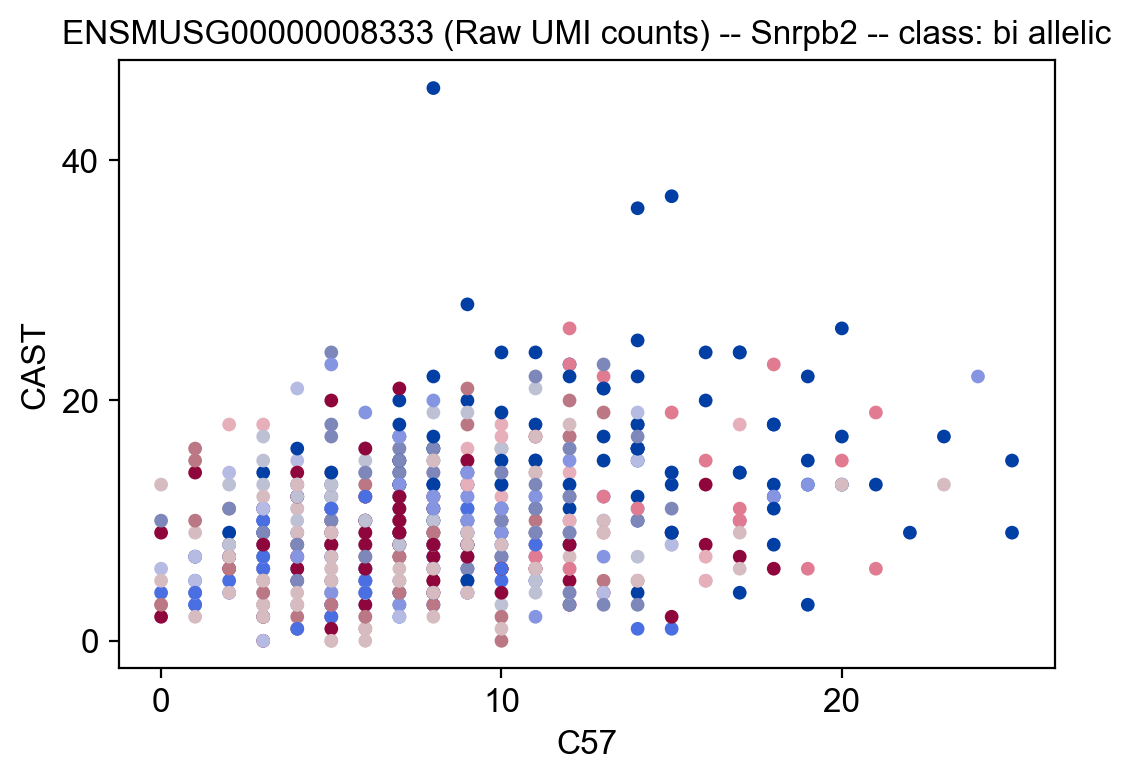

In [16]:
x = bi_allelic_index[random.randint(0,len(bi_allelic_index) - 1)]
scv.pl.scatter(adata, x, color=['clusters'], xlabel='C57', ylabel='CAST', 
               title=f"{x} (Raw UMI counts) -- {(adata.var.loc[x]['gene_name'])} -- class: bi_allelic")

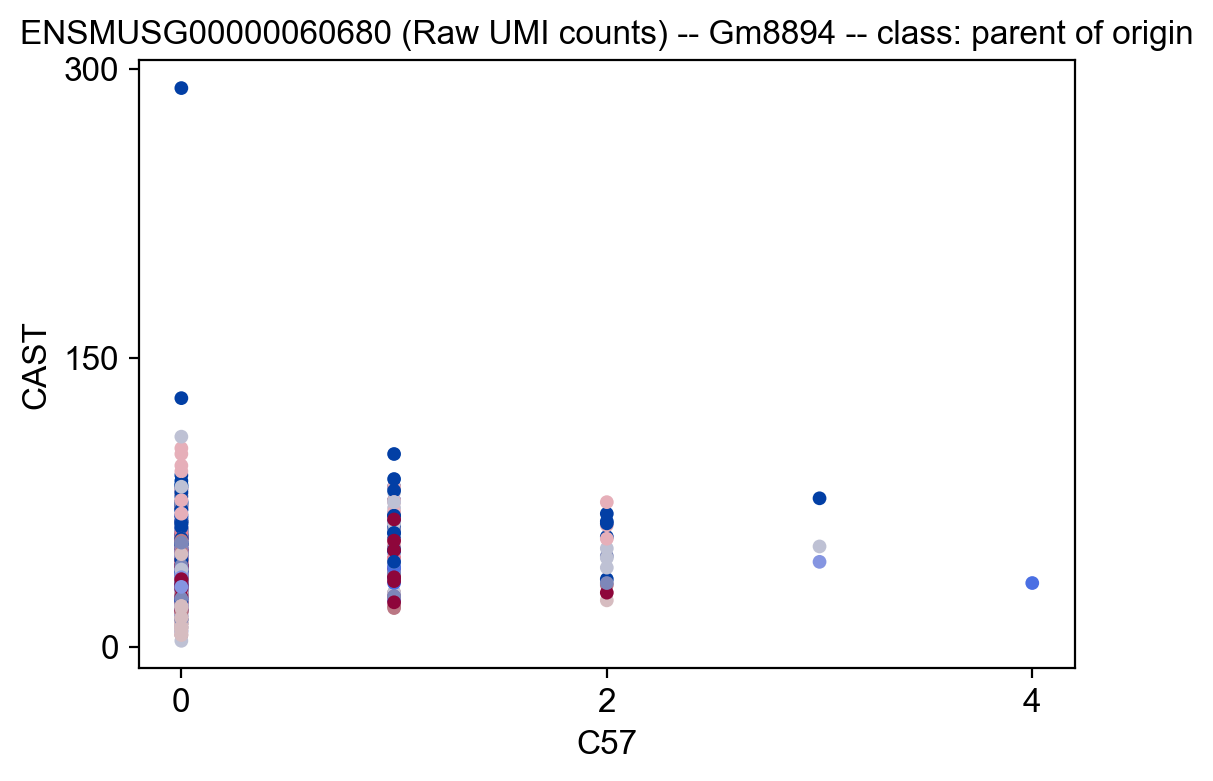

In [17]:
x = parent_of_origin_index[random.randint(0,len(parent_of_origin_index) - 1)]
scv.pl.scatter(adata, x, color=['clusters'], xlabel='C57', ylabel='CAST', 
               title=f"{x} (Raw UMI counts) -- {(adata.var.loc[x]['gene_name'])} -- class: parent_of_origin")

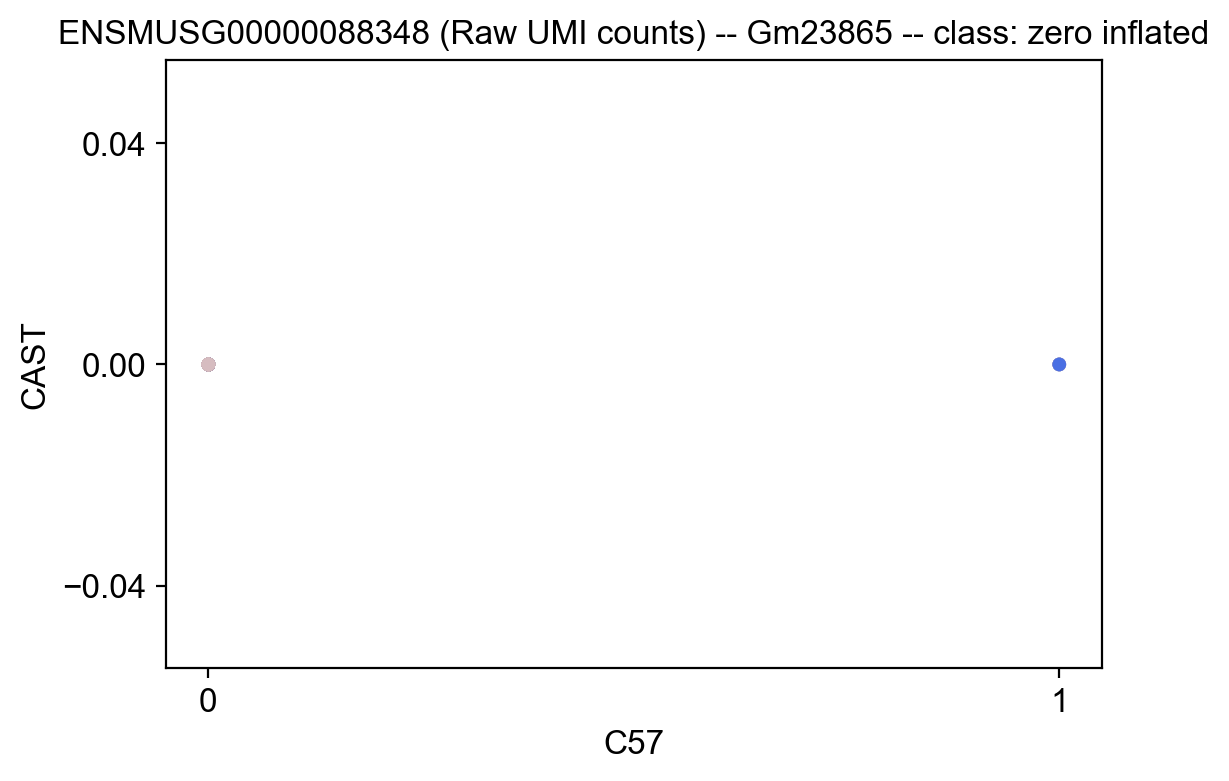

In [18]:
x = zero_inflated_index[random.randint(0,len(zero_inflated_index) - 1)]
scv.pl.scatter(adata, x, color=['clusters'], xlabel='C57', ylabel='CAST', 
               title=f"{x} (Raw UMI counts) -- {(adata.var.loc[x]['gene_name'])} -- class: zero_inflated")

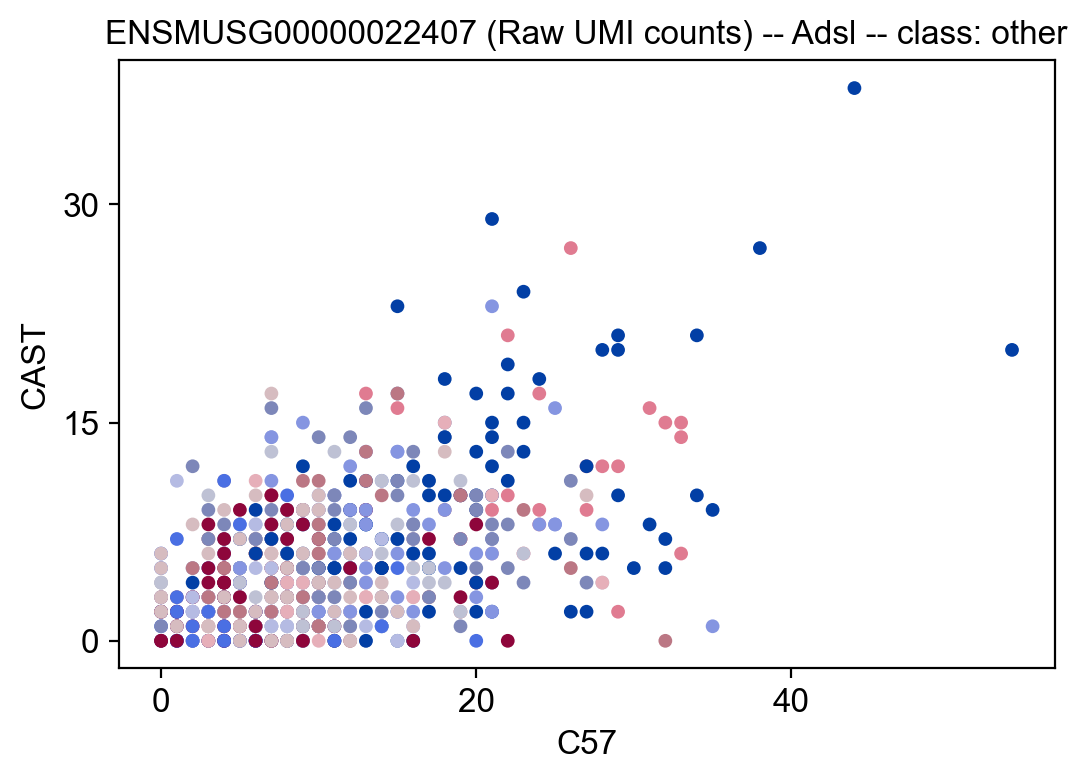

In [19]:
x = other_index[random.randint(0,len(other_index) - 1)]
scv.pl.scatter(adata, x, color=['clusters'], xlabel='C57', ylabel='CAST', 
               title=f"{x} (Raw UMI counts) -- {(adata.var.loc[x]['gene_name'])} -- class: other")

In [20]:
# labelling data

In [21]:
label = []
class_name = []
for x in adata.var.index:
    if x in bi_allelic_index:
        label.append(0)
    elif x in parent_of_origin_index:
        label.append(1)
    elif x in zero_inflated_index:
        label.append(3)
    else:
        label.append(2)
adata.var['class_label'] = label

In [22]:
adata.var.head(5)

,gene_name,chromosome,autosomes,nuclear,Ribosomal_prot,sum_allele_1,sum_allele_2,ratio_allele_1,ratio_allele_2,ratio_sum_allele_1,ratio_sum_allele_2,ratio_mean_allele_1,ratio_mean_allele_2,ratio_std_allele_1,ratio_std_allele_2,p_value,class_label
ENSMUSG00000000001,Gnai3,3,autosome,nuclear,other protein,8956.0,10024.0,0.471865,0.528135,321.291178,360.708822,0.471101,0.528899,0.157535,0.157535,0.001223,0
ENSMUSG00000000049,Apoh,11,autosome,nuclear,other protein,46.0,48.0,0.489362,0.510638,29.500000,34.500000,0.460938,0.539062,0.498447,0.498447,1.000000,3
ENSMUSG00000000088,Cox5a,9,autosome,nuclear,other protein,7514.0,7028.0,0.516710,0.483290,350.605317,331.394683,0.514084,0.485916,0.151797,0.151797,0.089846,0
ENSMUSG00000000120,Ngfr,11,autosome,nuclear,other protein,0.0,4.0,0.000000,1.000000,0.000000,3.000000,0.000000,1.000000,0.000000,0.000000,1.000000,3
ENSMUSG00000000184,Ccnd2,6,autosome,nuclear,other protein,36198.0,33010.0,0.523032,0.476968,357.947744,324.052256,0.524850,0.475150,0.144606,0.144606,0.020103,0


In [23]:
# GEnerating shuffled training and test data for ml 

In [24]:
allele_1 = pd.DataFrame(adata.layers['spliced'], columns=adata.var.index)
allele_2 = pd.DataFrame(adata.layers['unspliced'], columns=adata.var.index)

In [25]:
allele_1_T = allele_1.transpose(copy=True)
allele_2_T = allele_2.transpose(copy=True)

In [26]:
# differentiating allele 1 and allele 2 UMI counts
allele_T = (allele_1_T - allele_2_T) / (allele_1_T + allele_2_T)

In [27]:
allele_T['class_label'] = adata.var['class_label']

In [28]:
allele_T.head(5)

,0,1,2,3,4,5,6,7,8,9,...,673,674,675,676,677,678,679,680,681,class_label
ENSMUSG00000000001,0.428571,-0.500000,-0.371429,-0.133333,0.142857,-0.260870,-0.174603,-0.478261,-0.052632,-0.333333,...,-0.428571,-0.066667,-0.090909,0.230769,-0.04,-0.100,0.142857,0.125000,0.166667,0
ENSMUSG00000000049,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
ENSMUSG00000000088,0.176471,0.571429,0.304348,0.333333,-0.200000,0.588235,0.296296,-0.280000,0.313433,-0.448276,...,0.000000,-1.000000,-0.200000,0.000000,0.00,0.000,-0.428571,-1.000000,0.333333,0
ENSMUSG00000000120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
ENSMUSG00000000184,-0.284553,0.888889,-0.243902,0.082803,0.368421,-0.418919,0.576923,0.250000,-0.393939,-0.100000,...,0.020408,0.317073,0.162791,-0.081081,0.10,0.075,0.067797,-0.333333,-0.241379,0


In [29]:
test_set_1=allele_T[allele_T['class_label']==0].head(60).index
test_set_2=allele_T[allele_T['class_label']==1].head(8).index
test_set_3=allele_T[allele_T['class_label']==2].head(43).index
test_set_4=allele_T[allele_T['class_label']==3].head(83).index

test_set = test_set_1.union(test_set_2)
test_set = test_set.union(test_set_3)
test_set = test_set.union(test_set_4)
test_set = list(set(test_set))

test_set_suffled = random.sample(test_set, len(test_set))
test_set_suffled[:5]

['ENSMUSG00000005161',
 'ENSMUSG00000021539',
 'ENSMUSG00000004846',
 'ENSMUSG00000001555',
 'ENSMUSG00000021234']

In [30]:
test_set_csv = allele_T.loc[test_set_suffled]

In [31]:
test_set_csv.to_csv("data/classifier/test_set_7.csv", sep=";")

In [32]:
train_set = [x for x in list(allele_T.index) if x not in test_set_suffled]
len(train_set)

2940

In [33]:
train_set_suffled = random.sample(train_set, len(train_set))
train_set_suffled[:5]

['ENSMUSG00000039146',
 'ENSMUSG00000085199',
 'ENSMUSG00000076497',
 'ENSMUSG00000016257',
 'ENSMUSG00000022587']

In [34]:
train_set_csv = allele_T.loc[train_set_suffled]

In [35]:
train_set_csv

,0,1,2,3,4,5,6,7,8,9,...,673,674,675,676,677,678,679,680,681,class_label
ENSMUSG00000039146,NaN,NaN,NaN,-1.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
ENSMUSG00000085199,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
ENSMUSG00000076497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
ENSMUSG00000016257,-0.333333,-0.230769,0.391304,0.238095,-0.120000,0.600000,0.259259,0.500000,0.500000,0.375000,...,NaN,0.333333,0.200000,0.000000,-0.222222,0.120000,1.000000,0.333333,0.142857,2
ENSMUSG00000022587,0.100000,-0.142857,0.500000,0.423077,0.263158,-0.217391,0.194805,1.000000,0.181818,0.500000,...,1.000000,1.000000,0.629630,0.666667,0.307692,0.909091,0.692308,0.200000,0.500000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000061559,0.176471,-0.294118,0.111111,0.428571,0.111111,-0.714286,-0.090909,-0.071429,0.200000,-0.833333,...,-0.666667,0.000000,-0.529412,0.000000,-0.444444,-0.272727,0.523810,0.333333,-0.125000,0
ENSMUSG00000035212,0.166667,-0.230769,-0.023256,-0.046154,0.076923,0.111111,0.351351,0.440000,-0.166667,-0.162791,...,0.333333,0.200000,-0.032258,0.111111,-0.125000,-0.363636,-0.120000,-0.800000,0.571429,0
ENSMUSG00000022677,-0.411765,-0.444444,0.652174,0.428571,0.444444,-0.818182,0.240000,0.212121,0.043478,0.166667,...,-0.076923,-0.333333,0.000000,-0.473684,-0.333333,0.166667,-0.230769,0.142857,0.000000,0
ENSMUSG00000019916,-0.083333,-0.333333,-0.200000,0.459459,0.133333,0.185185,0.170732,-0.125000,-0.176471,0.000000,...,0.142857,-0.040000,-0.333333,0.375000,-0.368421,0.250000,0.166667,-0.230769,-0.058824,0


In [36]:
label_col = train_set_csv['class_label']
label_col

ENSMUSG00000039146    3
ENSMUSG00000085199    3
ENSMUSG00000076497    3
ENSMUSG00000016257    2
ENSMUSG00000022587    2
                     ..
ENSMUSG00000061559    0
ENSMUSG00000035212    0
ENSMUSG00000022677    0
ENSMUSG00000019916    0
ENSMUSG00000093966    3
Name: class_label, Length: 2940, dtype: int64

In [37]:
train_set_csv_shuffle_col = train_set_csv.drop('class_label', axis=1)
train_set_csv_shuffle_col

,0,1,2,3,4,5,6,7,8,9,...,672,673,674,675,676,677,678,679,680,681
ENSMUSG00000039146,NaN,NaN,NaN,-1.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENSMUSG00000085199,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENSMUSG00000076497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENSMUSG00000016257,-0.333333,-0.230769,0.391304,0.238095,-0.120000,0.600000,0.259259,0.500000,0.500000,0.375000,...,0.454545,NaN,0.333333,0.200000,0.000000,-0.222222,0.120000,1.000000,0.333333,0.142857
ENSMUSG00000022587,0.100000,-0.142857,0.500000,0.423077,0.263158,-0.217391,0.194805,1.000000,0.181818,0.500000,...,0.615385,1.000000,1.000000,0.629630,0.666667,0.307692,0.909091,0.692308,0.200000,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000061559,0.176471,-0.294118,0.111111,0.428571,0.111111,-0.714286,-0.090909,-0.071429,0.200000,-0.833333,...,0.411765,-0.666667,0.000000,-0.529412,0.000000,-0.444444,-0.272727,0.523810,0.333333,-0.125000
ENSMUSG00000035212,0.166667,-0.230769,-0.023256,-0.046154,0.076923,0.111111,0.351351,0.440000,-0.166667,-0.162791,...,-0.548387,0.333333,0.200000,-0.032258,0.111111,-0.125000,-0.363636,-0.120000,-0.800000,0.571429
ENSMUSG00000022677,-0.411765,-0.444444,0.652174,0.428571,0.444444,-0.818182,0.240000,0.212121,0.043478,0.166667,...,-0.875000,-0.076923,-0.333333,0.000000,-0.473684,-0.333333,0.166667,-0.230769,0.142857,0.000000
ENSMUSG00000019916,-0.083333,-0.333333,-0.200000,0.459459,0.133333,0.185185,0.170732,-0.125000,-0.176471,0.000000,...,-0.090909,0.142857,-0.040000,-0.333333,0.375000,-0.368421,0.250000,0.166667,-0.230769,-0.058824


In [38]:
train_set_csv_shuffle_col = (train_set_csv_shuffle_col.transpose().sample(frac=1)).transpose()
train_set_csv_shuffle_col['class_label'] = label_col

In [39]:
train_set_csv_shuffle_col

,196,478,585,356,132,560,42,432,206,354,...,494,292,411,77,34,241,645,345,286,class_label
ENSMUSG00000039146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
ENSMUSG00000085199,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
ENSMUSG00000076497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
ENSMUSG00000016257,0.333333,0.800000,0.230769,0.076923,0.428571,0.000000,0.000000,-0.043478,0.052632,-0.200000,...,0.666667,-0.333333,0.461538,1.000000,-0.200000,0.285714,-0.600000,0.555556,0.473684,2
ENSMUSG00000022587,0.636364,0.666667,0.612903,0.120000,1.000000,-0.066667,0.454545,0.636364,0.000000,0.846154,...,0.655172,-0.333333,0.529412,0.000000,0.363636,0.500000,0.157895,0.600000,0.365854,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000061559,-0.400000,0.285714,-0.636364,1.000000,-0.280000,-0.333333,-0.411765,-0.304348,0.000000,0.600000,...,0.500000,-1.000000,0.066667,-0.142857,-0.071429,0.032258,0.037037,0.400000,0.083333,0
ENSMUSG00000035212,-0.200000,-0.133333,0.333333,0.238095,0.142857,0.368421,0.142857,0.391304,0.133333,0.189189,...,0.692308,0.230769,0.217391,0.478261,0.083333,0.500000,-0.333333,0.241379,0.130435,0
ENSMUSG00000022677,0.200000,-0.357143,-0.333333,0.176471,-0.882353,0.333333,-0.090909,-0.866667,0.000000,-0.388889,...,-0.222222,0.500000,-0.176471,0.125000,-0.280000,-0.052632,0.333333,0.428571,0.066667,0
ENSMUSG00000019916,0.272727,-0.351351,0.130435,0.600000,0.185185,0.125000,-0.142857,-0.625000,0.121951,0.300000,...,0.000000,0.181818,0.250000,-0.120000,0.333333,0.128205,0.000000,-0.250000,0.172414,0


In [40]:
train_set_csv.to_csv("data/classifier/train_set_7.csv", sep=";")